In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer

In [2]:
dir = ""

In [3]:
team_att_df = pd.read_csv(dir + "team_attributes.csv")

player_df = pd.read_csv(dir + "player.csv")

match_df = pd.read_csv(dir + "match_clean.csv")

league_df = pd.read_csv(dir + "league.csv")

country_df = pd.read_csv(dir + "country.csv")

player_att_df = pd.read_csv(dir + "player_attributes.csv")

team_df = pd.read_csv(dir + "team.csv", encoding = "ISO-8859-1")

In [4]:
player_att_df.shape

(183978, 40)

In [5]:
match_df.columns

Index(['Unnamed: 0', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_id', 'home_team_id', 'away_team_id', 'home_team_goal',
       'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object')

# Match team/player

In [6]:
match_df.groupby("away_team_id")["league_id"].nunique().value_counts()

1    299
Name: league_id, dtype: int64

In [7]:
match_df.groupby("home_team_id")["league_id"].nunique().value_counts()

1    299
Name: league_id, dtype: int64

In [8]:
col = [h for h in match_df.columns if "home_player" in h][0]

home_df = match_df[["season", "league_id", "match_id", "home_team_id", col]]

home_df.columns = ["season", "league_id", "match_id", "team_id", "player_id"]

for col in [h for h in match_df.columns if "home_player" in h][1:]:
    
    home = match_df[["season", "league_id", "match_id", "home_team_id", col]]
    
    home.columns = ["season", "league_id", "match_id", "team_id", "player_id"]
    
    home_df = pd.concat([home_df, home])

home_df = home_df.drop_duplicates()

In [9]:
col = [h for h in match_df.columns if "away_player" in h][0]

away_df = match_df[["season", "league_id", "match_id", "away_team_id", col]]

away_df.columns = ["season", "league_id", "match_id", "team_id", "player_id"]

for col in [h for h in match_df.columns if "away_player" in h][1:]:
    
    away = match_df[["season", "league_id", "match_id", "away_team_id", col]]
    
    away.columns = ["season", "league_id", "match_id", "team_id", "player_id"]

    away_df = pd.concat([away_df, away])

away_df = away_df.drop_duplicates()

In [10]:
season_team_player_df = pd.concat([home_df, away_df]).drop_duplicates()

In [11]:
season_team_player_df.isnull().sum()

season          0
league_id       0
match_id        0
team_id         0
player_id    7125
dtype: int64

In [12]:
season_team_player_df.isnull().groupby(season_team_player_df["season"]).mean()

,season,league_id,match_id,team_id,player_id
season,,,,,
2008/2009,0.0,0.0,0.0,0.0,0.045089
2009/2010,0.0,0.0,0.0,0.0,0.015590
2010/2011,0.0,0.0,0.0,0.0,0.011764
2011/2012,0.0,0.0,0.0,0.0,0.009923
2012/2013,0.0,0.0,0.0,0.0,0.007831
2013/2014,0.0,0.0,0.0,0.0,0.011215
2014/2015,0.0,0.0,0.0,0.0,0.004991
2015/2016,0.0,0.0,0.0,0.0,0.004334


In [13]:
temp = (season_team_player_df
        .player_id
        .isnull()
        .groupby([season_team_player_df["season"], season_team_player_df["league_id"]]).mean()
        .reset_index())

In [14]:
for l in temp["league_id"].unique():
    print(temp.loc[temp["league_id"]==l])
    print("----------------------------------------")

       season  league_id  player_id
0   2008/2009          1   0.211138
11  2009/2010          1   0.025937
22  2010/2011          1   0.009110
33  2011/2012          1   0.004924
44  2012/2013          1   0.002841
55  2013/2014          1   1.000000
66  2014/2015          1   0.004167
77  2015/2016          1   0.002841
----------------------------------------
       season  league_id  player_id
1   2008/2009       1729   0.004067
12  2009/2010       1729   0.000837
23  2010/2011       1729   0.001555
34  2011/2012       1729   0.001555
45  2012/2013       1729   0.000000
56  2013/2014       1729   0.000120
67  2014/2015       1729   0.001077
78  2015/2016       1729   0.000359
----------------------------------------
       season  league_id  player_id
2   2008/2009       4769   0.007190
13  2009/2010       4769   0.002034
24  2010/2011       4769   0.002512
35  2011/2012       4769   0.000598
46  2012/2013       4769   0.003110
57  2013/2014       4769   0.000478
68  2014/2015     

In [15]:
(set(season_team_player_df.loc[~season_team_player_df["player_id"].isnull(), "player_id"]) - 
 set(player_att_df["player_id"]))

set()

In [16]:
season_team_player_df = season_team_player_df.loc[~season_team_player_df["player_id"].isnull()]
season_team_player_df.shape

(542017, 5)

In [17]:
season_team_player_df.groupby(["match_id", "player_id"]).size().value_counts()

1    541991
2        13
dtype: int64

In [18]:
season_team_player_df.groupby(["match_id", "player_id"]).size().sort_values().tail(15)

match_id  player_id
888198    39487.0      1
          39447.0      1
530209    96623.0      2
857362    27488.0      2
483176    26523.0      2
653921    34003.0      2
658982    43230.0      2
493077    37900.0      2
1287019   41478.0      2
499619    27255.0      2
1043052   177126.0     2
509190    43283.0      2
654015    26117.0      2
875979    28955.0      2
1043052   307227.0     2
dtype: int64

In [19]:
season_team_player_df.loc[(season_team_player_df["match_id"]==1043052) & 
                          (season_team_player_df["player_id"]==307227)]

,season,league_id,match_id,team_id,player_id
12828,2011/2012,17642,1043052,9771,307227.0
12828,2011/2012,17642,1043052,4064,307227.0


In [20]:
(pd.Series(match_df.loc[match_df["match_id"]==530209,
                        [h for h in match_df.columns if "player" in h]].values[0])
 .value_counts())

96623.0    2
38471.0    1
37423.0    1
2790.0     1
37440.0    1
18628.0    1
33586.0    1
42310.0    1
39142.0    1
74747.0    1
37597.0    1
43374.0    1
37448.0    1
33820.0    1
33729.0    1
37434.0    1
38035.0    1
75192.0    1
33958.0    1
33022.0    1
dtype: int64

In [21]:
(pd.Series(match_df.loc[match_df["match_id"]==1043052,
                        [h for h in match_df.columns if "player" in h]].values[0])
 .value_counts())

177126.0    2
307227.0    2
98374.0     1
164105.0    1
163665.0    1
164062.0    1
98209.0     1
164098.0    1
164099.0    1
72782.0     1
45359.0     1
91473.0     1
29036.0     1
281338.0    1
22125.0     1
185918.0    1
26861.0     1
dtype: int64

# Clean player attributes

In [22]:
player_att_df["date"] = pd.to_datetime(player_att_df["date"])

In [23]:
player_att_df.columns

Index(['player_id', 'date', 'overall_rating', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [24]:
player_att_df.isnull().sum()

player_id                 0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving           

In [25]:
num_cols = [c for c in player_att_df.columns if c not in 
            ["player_id", "date", "preferred_foot", "attacking_work_rate", "defensive_work_rate"]]
for col in num_cols:
    print(col)
    print(round(player_att_df.groupby("player_id")[col].agg(lambda x: x.var()**0.5).mean(),2))
    print("--------------------------------------------------------")

overall_rating
2.97
--------------------------------------------------------
potential
2.85
--------------------------------------------------------
crossing
4.14
--------------------------------------------------------
finishing
3.99
--------------------------------------------------------
heading_accuracy
3.69
--------------------------------------------------------
short_passing
3.62
--------------------------------------------------------
volleys
2.61
--------------------------------------------------------
dribbling
3.91
--------------------------------------------------------
curve
2.75
--------------------------------------------------------
free_kick_accuracy
4.32
--------------------------------------------------------
long_passing
4.54
--------------------------------------------------------
ball_control
3.42
--------------------------------------------------------
acceleration
4.12
--------------------------------------------------------
sprint_speed
4.2
--------------------

In [26]:
player_att_df.groupby("player_id").size().value_counts()

8     498
7     491
6     484
9     442
5     433
18    404
20    397
4     393
19    392
10    391
21    389
22    385
23    359
15    358
16    357
17    354
11    346
13    343
12    340
14    339
3     331
25    327
24    317
26    287
27    247
29    214
28    213
30    182
2     158
31    140
33    124
32    117
34     96
36     74
35     72
37     54
38     52
39     33
41     25
40     24
42     15
43     12
46     10
45     10
44      9
48      6
50      4
47      4
56      2
53      2
51      1
52      1
54      1
55      1
dtype: int64

In [27]:
player_att_df = player_att_df.sort_values(["player_id", "date"])

In [28]:
player_att_df.dtypes

player_id                       int64
date                   datetime64[ns]
overall_rating                float64
potential                     float64
preferred_foot                 object
attacking_work_rate            object
defensive_work_rate            object
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed                  float64
agility                       float64
reactions                     float64
balance                       float64
shot_power                    float64
jumping                       float64
stamina                       float64
strength                      float64
long_shots  

In [29]:
player_att_df.isnull().sum()

player_id                 0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving           

In [30]:
player_att_df["preferred_foot"].value_counts()

right    138409
left      44733
Name: preferred_foot, dtype: int64

In [31]:
player_att_df["preferred_foot"] = np.where(player_att_df["preferred_foot"]=="left", 0, 1)

In [32]:
player_att_df["attacking_work_rate"].value_counts()

medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64

In [33]:
for col in player_att_df.columns[2:]:
    player_att_df[col] = player_att_df.groupby("player_id")[col].ffill()

In [34]:
player_att_df.isnull().sum()

player_id                 0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    2445
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                1926
dribbling                 0
curve                  1926
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                1926
reactions                 0
balance                1926
shot_power                0
jumping                1926
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                 1926
penalties                 0
marking                   0
standing_tackle           0
sliding_tackle         1926
gk_diving           

In [35]:
for col in [c for c in player_att_df.columns[2:] if c not in ["attacking_work_rate", "defensive_work_rate"]]: 
    print(col)
    print(player_att_df.groupby("player_id")[col].nunique().value_counts())
    print("-------------------------------------------------------")

overall_rating
6     1417
7     1385
5     1310
4     1215
3     1142
8     1084
2     1019
9      815
1      636
10     512
11     260
12     149
13      70
14      29
15      10
16       5
18       1
17       1
Name: overall_rating, dtype: int64
-------------------------------------------------------
potential
5     1487
6     1457
3     1375
4     1358
7     1246
2     1214
8      952
1      784
9      597
10     344
11     140
12      77
13      17
14       7
15       3
17       1
16       1
Name: potential, dtype: int64
-------------------------------------------------------
preferred_foot
1    9812
2    1248
Name: preferred_foot, dtype: int64
-------------------------------------------------------
crossing
2     2107
3     1851
1     1635
4     1628
5     1326
6      952
7      724
8      401
9      240
10     106
11      55
12      25
13       9
18       1
Name: crossing, dtype: int64
-------------------------------------------------------
finishing
2     2180
3     1830
4     1

2     4159
3     3163
1     2195
4      961
5      164
7      108
6      108
8       94
9       53
10      27
11      15
12       8
13       2
15       1
14       1
18       1
Name: gk_positioning, dtype: int64
-------------------------------------------------------
gk_reflexes
2     4134
3     3129
1     2210
4      956
5      163
6      132
8      101
7       96
9       66
10      39
11      18
12      11
13       3
15       2
Name: gk_reflexes, dtype: int64
-------------------------------------------------------


In [36]:
player_att_df.isnull().sum()

player_id                 0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    2445
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                1926
dribbling                 0
curve                  1926
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                1926
reactions                 0
balance                1926
shot_power                0
jumping                1926
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                 1926
penalties                 0
marking                   0
standing_tackle           0
sliding_tackle         1926
gk_diving           

In [37]:
attack_defense_rate_mapping = {"high": 3, "medium": 2, "norm": 2, "ormal": 2, "low": 1}

In [38]:
player_att_df["attacking_work_rate_imp"] = player_att_df["attacking_work_rate"].map(attack_defense_rate_mapping)

In [39]:
player_att_df["attacking_work_rate_imp"].value_counts()

2.0    125961
3.0     42949
1.0      8614
Name: attacking_work_rate_imp, dtype: int64

In [40]:
player_att_df.attacking_work_rate_imp.isnull().sum()

6454

In [41]:
attack_cols = ["attacking_work_rate_imp"] + player_att_df.columns[7:-9].tolist()

In [42]:
attack_cols = (player_att_df[attack_cols].corr()["attacking_work_rate_imp"]
               .sort_values().tail(11).head(10).index.values)

In [43]:
player_att_df[attack_cols].isnull().sum()

long_shots         0
volleys         1926
crossing           0
curve           1926
finishing          0
positioning        0
dribbling          0
agility         1926
sprint_speed       0
acceleration       0
dtype: int64

In [44]:
player_att_df[attack_cols].var()**0.5

long_shots      18.365093
volleys         18.263053
crossing        17.245154
curve           18.260479
finishing       19.040732
positioning     18.440471
dribbling       17.751109
agility         12.949663
sprint_speed    12.567452
acceleration    12.978621
dtype: float64

In [45]:
attack_imp_df = (player_att_df[attack_cols]-player_att_df[attack_cols].mean())/player_att_df[attack_cols].std()

attack_imp_df["attacking_work_rate_imp"] = player_att_df["attacking_work_rate_imp"]

In [46]:
att_imp = KNNImputer(n_neighbors=30)

att_work_rate_imp = att_imp.fit_transform(attack_imp_df)

In [47]:
player_att_df["attacking_work_rate_imp"] = att_work_rate_imp[:,-1]

In [48]:
player_att_df.shape

(183978, 41)

In [49]:
player_att_df.columns

Index(['player_id', 'date', 'overall_rating', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes',
       'attacking_work_rate_imp'],
      dtype='object')

In [50]:
player_att_df["defensive_work_rate_imp"] = player_att_df["defensive_work_rate"].map(attack_defense_rate_mapping)

In [51]:
def_cols = ["defensive_work_rate_imp"] + player_att_df.columns[-25:-6].tolist()

def_cols = player_att_df[def_cols].corr()["defensive_work_rate_imp"].sort_values().tail(11).head(10).index.values

In [52]:
def_imp_df = (player_att_df[def_cols]-player_att_df[def_cols].mean())/player_att_df[def_cols].std()

def_imp_df["defensive_work_rate_imp"] = player_att_df["defensive_work_rate_imp"]

In [53]:
def_imp = KNNImputer(n_neighbors=30)

def_work_rate_imp = def_imp.fit_transform(def_imp_df)

In [54]:
player_att_df["defensive_work_rate_imp"] = def_work_rate_imp[:,-1]

In [55]:
player_att_df.groupby("defensive_work_rate_imp")["marking"].mean().sort_index()

defensive_work_rate_imp
1.000000    29.982507
1.100000    24.000000
1.200000    20.000000
1.233333    22.250000
1.266667    22.428571
1.300000    21.181818
1.333333    21.416667
1.366667    17.266667
1.400000    22.238095
1.433333    24.600000
1.466667    23.409091
1.500000    21.800000
1.533333    22.633333
1.566667    25.956522
1.600000    25.840580
1.633333    26.470588
1.666667    28.392857
1.700000    26.601504
1.733333    27.152941
1.766667    29.210526
1.800000    27.461538
1.833333    28.310881
1.866667    30.820106
1.900000    31.035176
1.933333    34.763333
1.966667    36.676829
2.000000    46.031425
2.033333    55.488235
2.066667    56.761273
2.100000    58.839506
2.133333    61.616477
2.166667    60.216418
2.200000    63.479705
2.233333    63.589212
2.266667    63.223301
2.300000    61.354497
2.333333    66.650000
2.366667    67.910569
2.400000    65.935484
2.433333    67.917808
2.466667    70.151515
2.500000    69.968254
2.533333    69.152174
2.566667    71.243243
2.600000

In [56]:
cols_to_imp = player_att_df.isnull().sum().reset_index()
cols_to_imp = [c for c in cols_to_imp.loc[cols_to_imp[0] > 1900, "index"].values if c != "attacking_work_rate"]

In [57]:
cols_to_imp

['volleys',
 'curve',
 'agility',
 'balance',
 'jumping',
 'vision',
 'sliding_tackle']

In [58]:
numeric_cols = player_att_df.select_dtypes([np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ["player_id", "preferred_foot"]]
numeric_cols

['overall_rating',
 'potential',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'attacking_work_rate_imp',
 'defensive_work_rate_imp']

In [59]:
for col in cols_to_imp:
    
    imp_col = (player_att_df[numeric_cols].corr()[col].sort_values().tail(11).head(10).index.values)
    
    imp_df = (player_att_df[imp_col]-player_att_df[imp_col].mean())/player_att_df[imp_col].std()

    imp_df[col] = player_att_df[col]
    
    imp = KNNImputer(n_neighbors=30)

    col_imp_df = imp.fit_transform(imp_df)
    
    player_att_df["{}_imp".format(col)] = col_imp_df[:,-1]

In [60]:
player_att_df.shape

(183978, 49)

In [61]:
player_att_df.to_csv(dir+"player_att_imp.csv")

In [62]:
#player_att_df = pd.read_csv(dir+"player_att_imp.csv")

# Tie attributes to match

In [63]:
col = [c for c in match_df.columns if "player" in c][0]

player_by_match_df = match_df[["date", "match_id", col]]

player_by_match_df.columns = ["date", "match_id", "player_id"]

for col in [c for c in match_df.columns if "player" in c][1:]:
    
    pbm_df = match_df[["date", "match_id", col]]
    
    pbm_df.columns = ["date", "match_id", "player_id"]
    
    player_by_match_df = pd.concat([player_by_match_df, pbm_df])
    
player_by_match_df = player_by_match_df.drop_duplicates()

player_by_match_df["date"] = pd.to_datetime(player_by_match_df["date"])

In [64]:
player_by_match_df.isnull().sum()

date            0
match_id        0
player_id    4868
dtype: int64

In [65]:
player_by_match_df = player_by_match_df.loc[~player_by_match_df["player_id"].isnull()]

In [66]:
player_att_df.rename(columns={'date':'attribute_date'}, inplace=True)

final_att_cols = [c for c in player_att_df.columns if col not in ["preferred_foot",
                                                                  "attacking_work_rate",
                                                                  "defensive_working_rate"]]

final_att_cols

['player_id',
 'attribute_date',
 'overall_rating',
 'potential',
 'preferred_foot',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'attacking_work_rate_imp',
 'defensive_work_rate_imp',
 'volleys_imp',
 'curve_imp',
 'agility_imp',
 'balance_imp',
 'jumping_imp',
 'vision_imp',
 'sliding_tackle_imp']

In [67]:
player_by_match_merged = player_by_match_df.merge(player_att_df[final_att_cols], on="player_id")

In [68]:
player_by_match_merged.shape

(11868330, 51)

In [69]:
player_by_match_merged["day_diff"] = (player_by_match_merged["date"] - 
                                      player_by_match_merged["attribute_date"]).dt.days

In [70]:
player_by_match_merged["day_diff"].value_counts().quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05      32.0
0.25     410.0
0.50    1125.0
0.75    2463.5
0.95    7412.7
Name: day_diff, dtype: float64

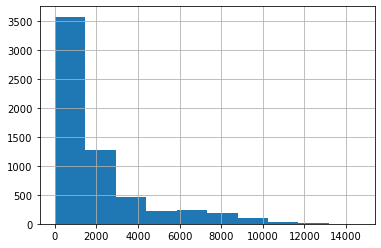

In [71]:
player_by_match_merged["day_diff"].value_counts().hist()

In [72]:
player_by_match_merged = player_by_match_merged.loc[player_by_match_merged["day_diff"] >= 0]

In [73]:
player_by_match_merged = player_by_match_merged.sort_values(["player_id", "date", "day_diff"])

In [74]:
player_by_match_merged.loc[player_by_match_merged["player_id"]==2625.0,
                           ["player_id", "date", "attribute_date", "day_diff"]].head(10)

,player_id,date,attribute_date,day_diff
8807078,2625.0,2009-03-01,2008-08-30,183
8807077,2625.0,2009-03-01,2007-08-30,549
8807076,2625.0,2009-03-01,2007-02-22,738
8807400,2625.0,2009-03-07,2008-08-30,189
8807399,2625.0,2009-03-07,2007-08-30,555
8807398,2625.0,2009-03-07,2007-02-22,744
8806770,2625.0,2009-03-14,2008-08-30,196
8806769,2625.0,2009-03-14,2007-08-30,562
8806768,2625.0,2009-03-14,2007-02-22,751
8807414,2625.0,2009-03-21,2008-08-30,203


In [75]:
player_by_match_merged = (player_by_match_merged
                          .sort_values(["player_id", "date", "day_diff"])
                          .groupby(["player_id", "date"]).head(1))

In [76]:
player_by_match_merged.loc[player_by_match_merged["player_id"]==2625.0,
                           ["player_id", "date", "attribute_date", "day_diff"]].head(10)

,player_id,date,attribute_date,day_diff
8807078,2625.0,2009-03-01,2008-08-30,183
8807400,2625.0,2009-03-07,2008-08-30,189
8806770,2625.0,2009-03-14,2008-08-30,196
8807414,2625.0,2009-03-21,2008-08-30,203
8807092,2625.0,2009-04-03,2008-08-30,216
8807428,2625.0,2009-04-11,2008-08-30,224
8806784,2625.0,2009-04-18,2008-08-30,231
8807442,2625.0,2009-04-25,2008-08-30,238
8807274,2625.0,2009-05-09,2008-08-30,252
8807288,2625.0,2009-05-16,2008-08-30,259


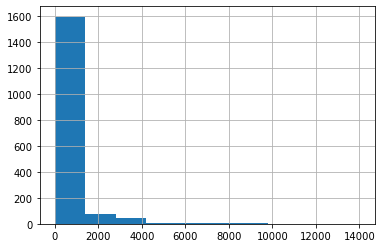

In [77]:
player_by_match_merged["day_diff"].value_counts().hist()

In [78]:
player_by_match_merged["day_diff"].value_counts().quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

0.00        1.0
0.05        1.0
0.25        2.0
0.50        5.0
0.75       25.0
0.95     2315.1
1.00    13996.0
Name: day_diff, dtype: float64

In [79]:
player_by_match_merged = player_by_match_merged.drop(["attribute_date"], axis=1)

In [80]:
player_by_match_merged.groupby(["date", "match_id", "player_id"]).size().value_counts()

1    542004
dtype: int64

In [81]:
player_by_match_df.groupby(["date", "match_id", "player_id"]).size().value_counts()

1    542004
dtype: int64

In [82]:
print(player_by_match_df.shape)
player_by_match_df = player_by_match_df.merge(player_by_match_merged, on=["date", "match_id", "player_id"])
print(player_by_match_df.shape)

(542004, 3)
(542004, 51)


In [83]:
player_by_match_df.isnull().sum()

date                          0
match_id                      0
player_id                     0
overall_rating                0
potential                     0
preferred_foot                0
attacking_work_rate        8448
defensive_work_rate           0
crossing                      0
finishing                     0
heading_accuracy              0
short_passing                 0
volleys                    6722
dribbling                     0
curve                      6722
free_kick_accuracy            0
long_passing                  0
ball_control                  0
acceleration                  0
sprint_speed                  0
agility                    6722
reactions                     0
balance                    6722
shot_power                    0
jumping                    6722
stamina                       0
strength                      0
long_shots                    0
aggression                    0
interceptions                 0
positioning                   0
vision  

In [84]:
player_by_match_df = player_by_match_df.drop(cols_to_imp + ["attacking_work_rate", "defensive_work_rate"], axis=1)

In [85]:
player_by_match_df.groupby(["match_id", "player_id"]).size().sort_values().tail(15)

match_id  player_id
888198    41023.0      1
          39699.0      1
          39487.0      1
          39447.0      1
          39401.0      1
          39376.0      1
          39345.0      1
          39323.0      1
          38717.0      1
          38118.0      1
          37545.0      1
          33782.0      1
          31938.0      1
          41475.0      1
2216672   480778.0     1
dtype: int64

In [86]:
season_team_player_df.groupby(["match_id", "player_id"]).size().value_counts()

1    541991
2        13
dtype: int64

In [90]:
player_by_match_df.groupby(["match_id", "player_id"]).size().value_counts()

1    542004
dtype: int64

In [91]:
print(player_by_match_df.shape)
player_by_match_df = player_by_match_df.merge(season_team_player_df[["match_id", "team_id", "player_id"]],
                                              on=["match_id", "player_id"])
print(player_by_match_df.shape)

(542004, 42)
(542017, 43)


In [92]:
player_by_match_df.to_csv(dir+"player_attributes_by_match.csv")

In [26]:
df=pd.read_csv(dir+"player_attributes_by_match.csv")

In [27]:
df.columns

Index(['Unnamed: 0', 'date', 'match_id', 'player_id', 'overall_rating',
       'potential', 'preferred_foot', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'dribbling', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'reactions', 'shot_power', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'penalties', 'marking',
       'standing_tackle', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes', 'attacking_work_rate_imp',
       'defensive_work_rate_imp', 'volleys_imp', 'curve_imp', 'agility_imp',
       'balance_imp', 'jumping_imp', 'vision_imp', 'sliding_tackle_imp',
       'day_diff', 'team_id'],
      dtype='object')